In [52]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Small Businesses Survey - US

The objective of the survey is to gather information about the effects of the current COVID-19 publichealth crisis on small businesses in the United States.  The survey is structured in the followingmanner:
* Questions about original size of firm and number of layoffs
* Questions about possible bankruptcy
* Questions about awareness of government programs
* Questions about their willingness to participate in our study

The survey was implemented through Qualtrics, and launched on March 27.  Using facebook ads,we targeted the counties with the highest incidence of COVID-19 cases.  We received 300 responsesfrom March 27 to March 30

In [1]:
#Import libraries
import os, sys
import pandas as pd
import numpy as np
import socket
import seaborn as sns
from small_biz import data_getter



In [2]:
#1. Import data
print("IMPORT DATA ...")
surveyData = data_getter.get_surv_data('us')

#2. Clean Data
print("DATA CLEANING ...")
yesnoList= ['q3.1', 'q4.1','q5.1','q7.1','q7.2_1','q7.2_2','q7.2_3','q7.2_4','q8.1']

for var in yesnoList:
    surveyData[var] = surveyData[var].str.lower()
    surveyData['p'+var] = list(map(lambda x: 1 if x == 'yes' else (0 if x == 'no' else np.nan), surveyData[var]))

qCode =  ['q2.1_1','q2.1_2',
         'q3.2_1', 'q3.2_2',
         'q4.2_1','q4.2_2',
         'q5.2',
         'q6.1_2']

for var in qCode:
    surveyData['p'+var] = surveyData[var].astype(float)

surveyData = surveyData.dropna(subset=['pq2.1_1'])
surveyData['totEmp'] = surveyData['pq2.1_1'] + surveyData['pq2.1_2']
surveyData['noemp'] = (surveyData['totEmp'] == 0) | (surveyData['totEmp'] > 300)
surveyData  = surveyData.loc[surveyData['noemp'] != True,:] #Eliminate all bussineses without employeess
surveyData['noLayOffFirm'] = (surveyData['pq3.1'] == 0) & (surveyData['pq4.1'] == 0)
surveyData['noLayOffFirm'].sum()/surveyData['noLayOffFirm'].shape[0]


IMPORT DATA ...
Progress = 65.68
Progress = 100.00
Progress = 100.00
DATA CLEANING ...


0.2007042253521127

### Figure 1: Number of full-time employees

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Number of full time employees')]

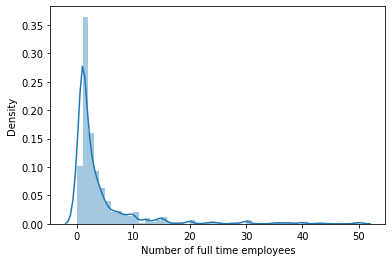

In [3]:
ax = sns.distplot(surveyData['pq2.1_1'])
ax.set(xlabel='Number of full time employees', ylabel='Density')


### Figure 2: Number of part-time employees

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Number of part time employees')]

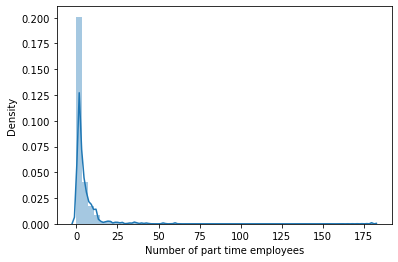

In [4]:
ax = sns.distplot(surveyData['pq2.1_2'])
ax.set(xlabel='Number of part time employees', ylabel='Density')

### Figure 3: Number of total employees 

[Text(0, 0.5, 'Number of Businesses'), Text(0.5, 0, 'Total Employees')]

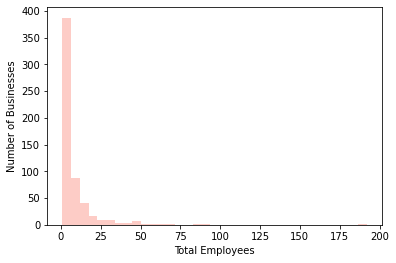

In [5]:
ax = sns.distplot(surveyData['totEmp'].astype(int), kde=False, bins=35, color='salmon')
ax.set(xlabel='Total Employees', ylabel='Number of Businesses')

### Figure 4: Number of total employees, binned

[Text(0, 0.5, 'Number of businesses'), Text(0.5, 0, 'Size of business')]

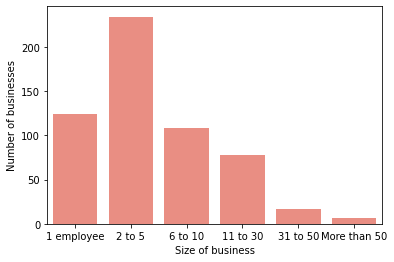

In [6]:
surveyData['totEmpByGroup'] = list(map(lambda x: '1 employee' if  x == 1 else
                                                ('2 to 5' if 1 < x <= 5 else
                                                ('6 to 10' if 5 < x <= 10 else
                                                ('11 to 30' if 10 < x <= 30 else
                                                ('31 to 50' if 30 < x <= 50 else 'More than 50')))), 
                                                surveyData['totEmp']))

firmSizeCategories= ['1 employee','2 to 5','6 to 10','11 to 30','31 to 50', 'More than 50']
ax = sns.countplot(x = surveyData['totEmpByGroup'], order=firmSizeCategories,color='salmon')
ax.set(xlabel='Size of business', ylabel='Number of businesses')

### Figure 5: Number of employees laid off

[Text(0, 0.5, 'Number of businesses'),
 Text(0.5, 0, 'Total number of people laid off')]

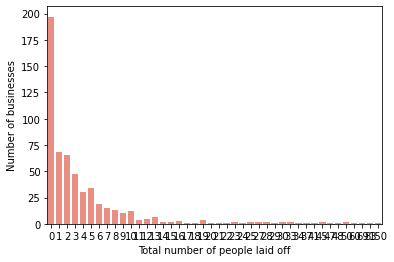

In [11]:
surveyData['pq3.2_1'] = surveyData['pq3.2_1'].fillna(0)
surveyData['pq3.2_2'] = surveyData['pq3.2_2'].fillna(0)
surveyData['totUnemp'] = surveyData['pq3.2_1'] + surveyData['pq3.2_2']
ax = sns.countplot(x =surveyData['totUnemp'].astype(int), color='salmon')
ax.set(xlabel='Total number of people laid off', ylabel='Number of businesses')

### Figure 6: Number of employees laid off, binned


[Text(0, 0.5, 'Number of businesses'),
 Text(0.5, 0, 'Number of people laid off')]

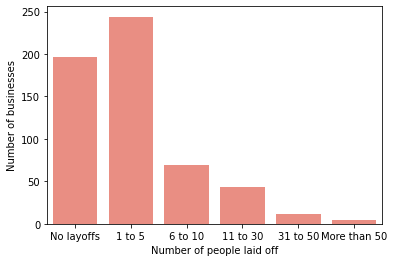

In [10]:
surveyData['totUnempByGroup'] = list(map(lambda x: 'No layoffs' if x == 0 else
                                                ('1 to 5' if 1 <= x <= 5 else
                                                ('6 to 10' if 5 < x <= 10 else
                                                ('11 to 30' if 10 < x <= 30 else
                                                ('31 to 50' if 30 < x <= 50 else 'More than 50')))), 
                                                surveyData['totUnemp']))
ax = sns.countplot(x = surveyData['totUnempByGroup'], 
                   order=['No layoffs', '1 to 5','6 to 10','11 to 30','31 to 50', 'More than 50'],color='salmon')
ax.set(xlabel='Number of people laid off', ylabel='Number of businesses')

### Figure 7: Share of employees laid off by size of business

[Text(0, 0.5, 'Rate of unemployed'), Text(0.5, 0, 'Firm Size')]

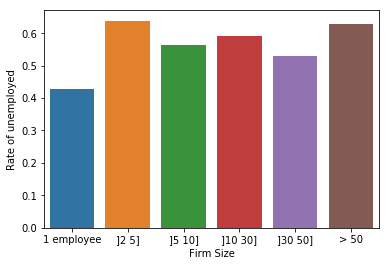

In [24]:
surveyDataByGroup = surveyData[['totUnemp','totEmp','totEmpByGroup']].groupby(['totEmpByGroup']).sum()
surveyDataByGroup['unemploymentRate'] = surveyDataByGroup['totUnemp']/ surveyDataByGroup['totEmp']

ax = sns.barplot(x = surveyDataByGroup.index, y = surveyDataByGroup['unemploymentRate'], order=firmSizeCategories)
ax.set(xlabel='Firm Size', ylabel='Rate of unemployed')

### Figure 8: Number of employees laid off by size of business

[Text(0, 0.5, 'Number of unemployed'), Text(0.5, 0, 'Firm Size')]

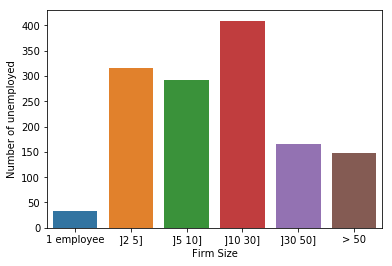

In [27]:
ax = sns.barplot(x = surveyDataByGroup.index, y = surveyDataByGroup['totUnemp'], order=firmSizeCategories)
ax.set(xlabel='Firm Size', ylabel='Number of unemployed')


### Figure 9: Share of employees laid off

[Text(0, 0.5, 'Numer of businesses'),
 Text(0.5, 0, 'Share of laid off employees')]

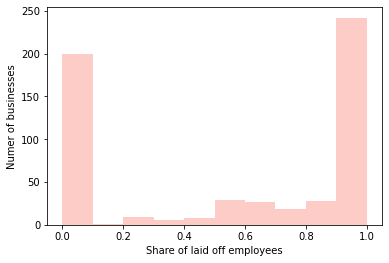

In [12]:
surveyData['firm_layoffShare'] = surveyData['totUnemp']/surveyData['totEmp']
ax = sns.distplot(surveyData['firm_layoffShare'], bins=10, kde=False,color='salmon')
ax.set(xlabel='Share of laid off employees', ylabel='Numer of businesses')

### Figure 10: Share of firms that will not lay off workers

[Text(0, 0.5, 'Share of firms that will not lay off workers'),
 Text(0.5, 0, 'Firm Size')]

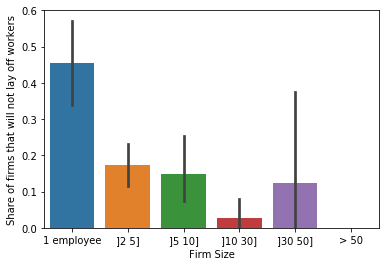

In [31]:
ax = sns.barplot(x = surveyData['totEmpByGroup'], y = surveyData['noLayOffFirm'], order=firmSizeCategories)
ax.set(xlabel='Firm Size', ylabel='Share of firms that will not lay off workers')


### Figure 11: Probability of recovery in next two years by size of business

[Text(0, 0.5, 'Percentage thinks will recover within 2 years'),
 Text(0.5, 0, 'Size of business')]

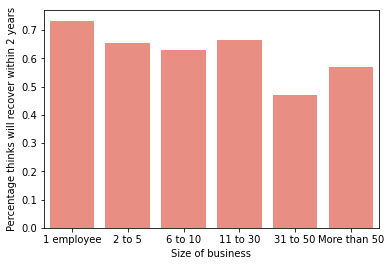

In [18]:
surveyData['counter'] = 1
surveyDataByGroup = surveyData[['pq5.1','counter','totEmpByGroup']].groupby(['totEmpByGroup']).sum()
surveyDataByGroup['optimistRate'] = surveyDataByGroup['pq5.1']/ surveyDataByGroup['counter']
ax = sns.barplot(x = surveyDataByGroup.index, y = surveyDataByGroup['optimistRate'], 
                 order=firmSizeCategories, color='salmon')
ax.set(xlabel='Size of business', ylabel='Percentage thinks will recover within 2 years')

### Figure 12: Estimated time for recovery (in months)

[Text(0, 0.5, 'Number of businesses'),
 Text(0.5, 0, 'Estimated time for recovery (in months)')]

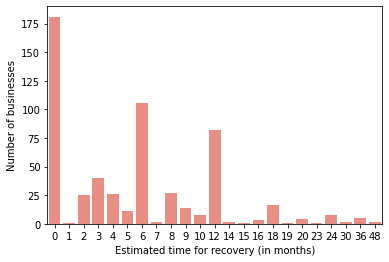

In [17]:
surveyData['q5.2'] = surveyData['q5.2'].fillna(0)
ax = sns.countplot(surveyData['q5.2'].astype(int), color='salmon')
ax.set(xlabel='Estimated time for recovery (in months)', ylabel='Number of businesses')

### Figure 13: Average time for recovery by firm size

[Text(0, 0.5, 'Estimated time for recovery (in months)'),
 Text(0.5, 0, 'Firm Size')]

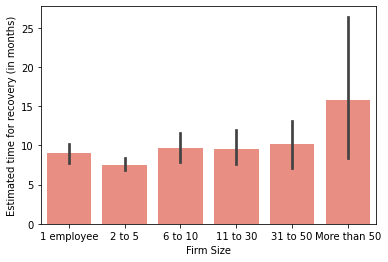

In [16]:
ax = sns.barplot(x = surveyData['totEmpByGroup'], 
                 y = surveyData['pq5.2'], order=firmSizeCategories, color='salmon')
ax.set(xlabel='Firm Size', ylabel='Estimated time for recovery (in months)')

### Figure 14: Distribution of the probability to file bankruptcy


[Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'Probability to file bankruptcy in the next 6 months')]

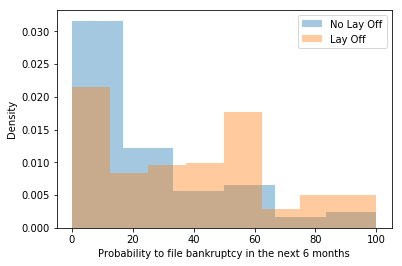

In [46]:
surveyData['probBankruptcy'] = surveyData['pq6.1_2']
surveyData['nMonthsCrisis'] = surveyData['pq5.2']
ax = sns.distplot(surveyData.loc[surveyData['noLayOffFirm']==1,'probBankruptcy'],norm_hist=True, kde=False, label="No Lay Off")
ax = sns.distplot(surveyData.loc[surveyData['noLayOffFirm']==0,'probBankruptcy'],norm_hist=True, kde=False, label="Lay Off")
ax.legend()
ax.set(xlabel='Probability to file bankruptcy in the next 6 months', ylabel='Density')

### Figure 15: Awareness of government relief policies by size of business

[Text(0, 0.5, 'Percentage aware of govt. relief measures'),
 Text(0.5, 0, 'Size of business')]

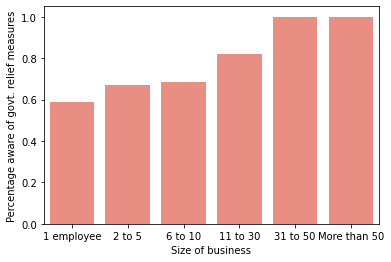

In [20]:
surveyData['counter'] = 1
surveyDataByGroup = surveyData[['pq7.1','counter','totEmpByGroup']].groupby(['totEmpByGroup']).sum()
surveyDataByGroup['awarenessRate'] = surveyDataByGroup['pq7.1']/ surveyDataByGroup['counter']

ax = sns.barplot(x = surveyDataByGroup.index, y = surveyDataByGroup['awarenessRate'], 
                 order=firmSizeCategories, color='salmon')
ax.set(xlabel='Size of business', ylabel='Percentage aware of govt. relief measures')